## Shor’s Algorithm to Factor a Number

Currently, a significant portion of our online security relies on `RSA (Rivest–Shamir–Adleman)` encryption. RSA encryption leverages the fact that factoring large numbers is significantly more challenging than multiplying them together. While multiplication is relatively straightforward, the complexity of factoring increases exponentially as the input size grows. However, with the advent of powerful quantum computers, the difficulty of factoring numbers increases polynomially instead of exponentially. While it may still take several years before quantum computers running Shor's algorithm pose a significant cybersecurity threat, the algorithm can already be used to factor small numbers.

The brilliance of Peter Shor's algorithm lies in its approach of treating factoring as a problem of finding repeating patterns, known as period finding. By appropriately framing the problem, the algorithm can highly likely determine the factors of a given number N. Exploring this algorithm is not only a fascinating endeavor due to its renown but also offers valuable insights into important topics in quantum computing. These include the `Quantum Fourier Transform` and the `Quantum Phase Estimation algorithm`.

### Quantum Fourier Transform


In [1]:
import numpy as np
# importing Qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

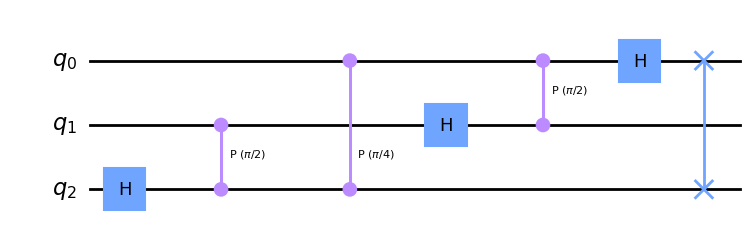

In [2]:
# 3 qubit example

qc = QuantumCircuit(3)
qc.h(2)
qc.cp(np.pi/2, 1, 2) # CROT from qubit 1 to qubit 2
qc.cp(np.pi/4, 0, 2) # CROT from qubit 0 to qubit 2
qc.h(1)
qc.cp(np.pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.swap(0, 2) #swaps qubit 0 and 2
qc.draw('mpl')

In [3]:
# General QFT function

def qft_rot(circuit, n):
    '''
        circuit: given quantum circuit
        n: number of qubit 
    '''
    if n==0:
        return circuit
    n -= 1   # we want the qubit indexing to go from 0 to n-2
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    
    qft_rot(circuit, n) # recursively call the function to repeat the process for next n-1 qubits

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-1-qubit)
    return circuit

def qft(circuit, n):
    ''' QFT on the n qubits
    '''
    qft_rot(circuit, n)
    swap_registers(circuit, n)
    return circuit

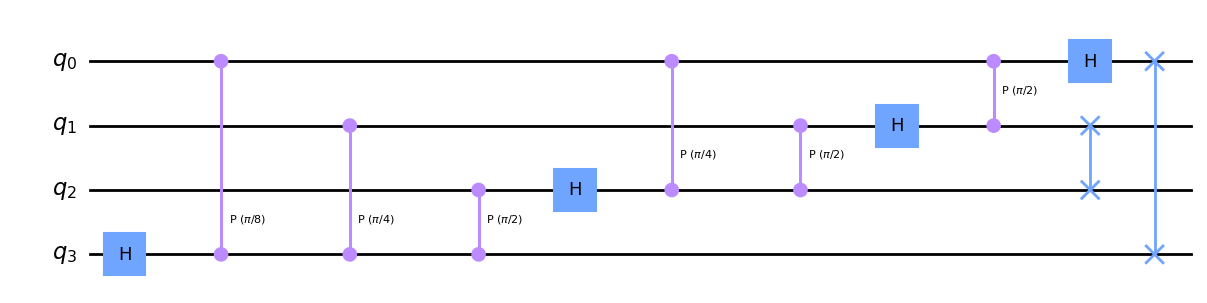

In [4]:
# Draw the circuit with n=4
qc = QuantumCircuit(4)
qft(qc, 4)
qc.draw('mpl')

In [5]:
bin(13)

'0b1101'

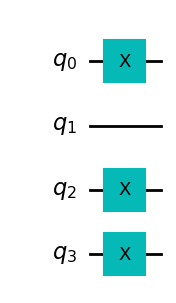

In [6]:
# Checking the circuit with 13='1101'
#quantum circuit that encodes '1101'
qc = QuantumCircuit(4)
qc.x([0,2,3])
qc.draw('mpl')

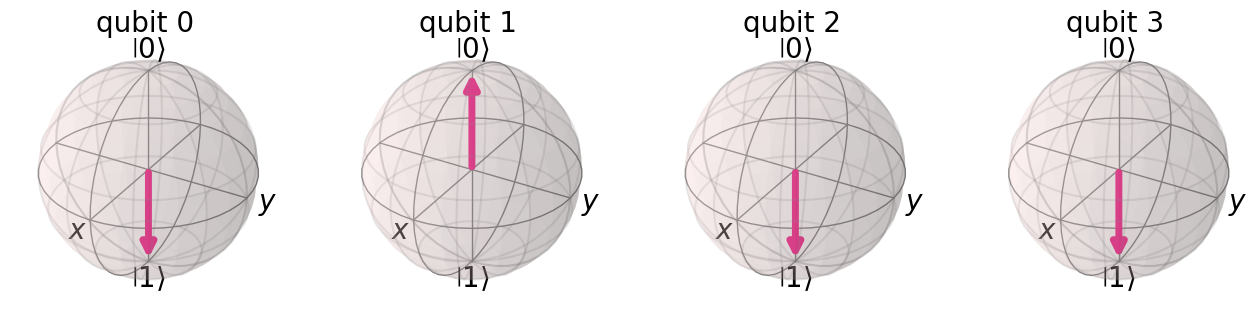

In [7]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

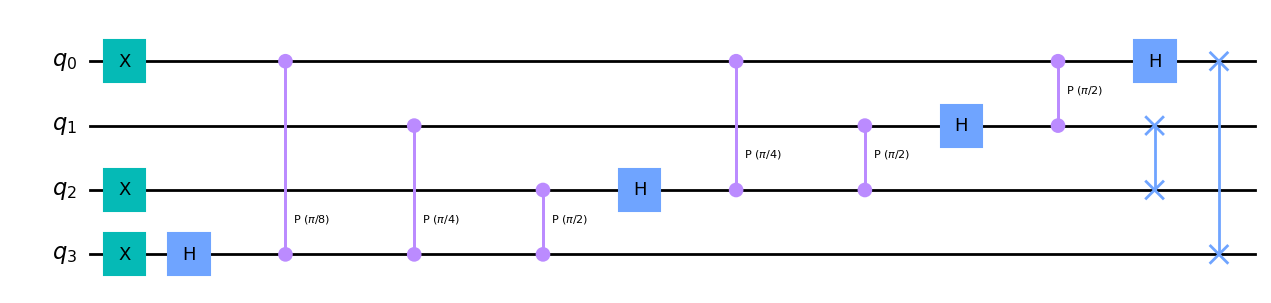

In [8]:
qft(qc, 4)
qc.draw('mpl')

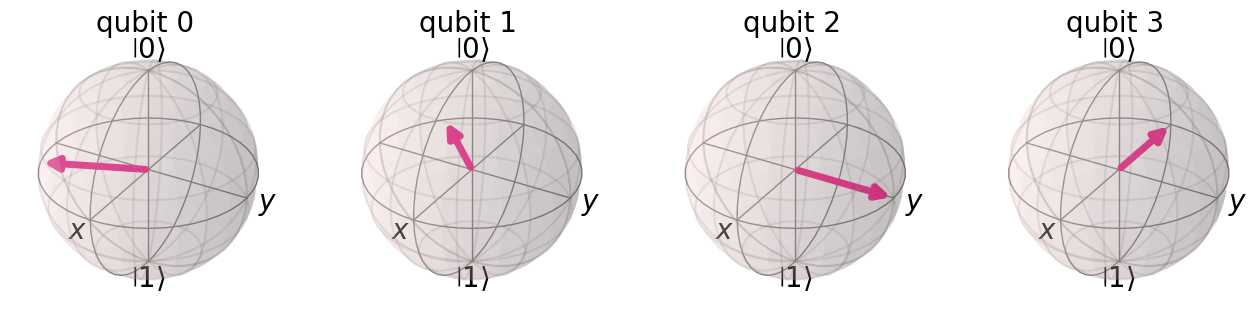

In [9]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

In [10]:
# Inverse QFT 

def inv_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

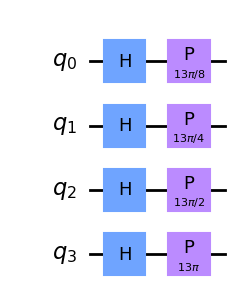

In [11]:
# Create the state |13>

state = 13
qc1 = QuantumCircuit(4)
for qubit in range(4):
    qc1.h(qubit)
qc1.p(state*np.pi/8, 0)
qc1.p(state*np.pi/4, 1)
qc1.p(state*np.pi/2, 2)
qc1.p(state*np.pi, 3)

qc1.draw('mpl')

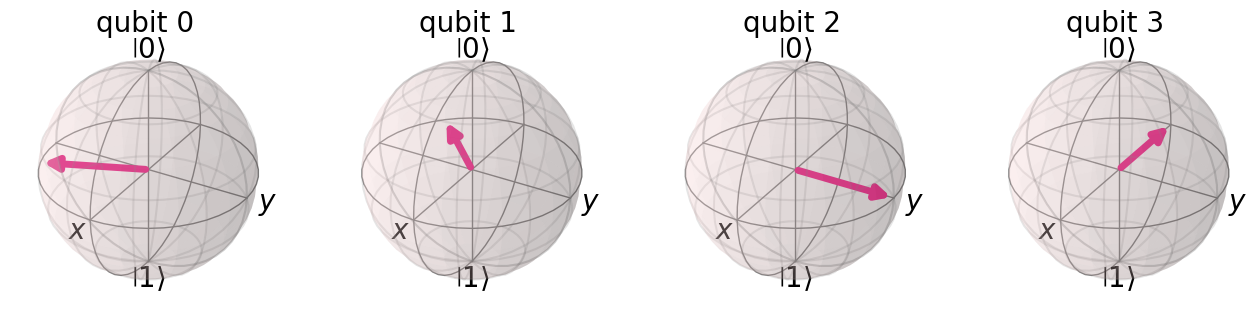

In [12]:
# Check this creates the state |13>
qc1_init = qc1.copy()
qc1_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc1_init).result().get_statevector()
plot_bloch_multivector(statevector)

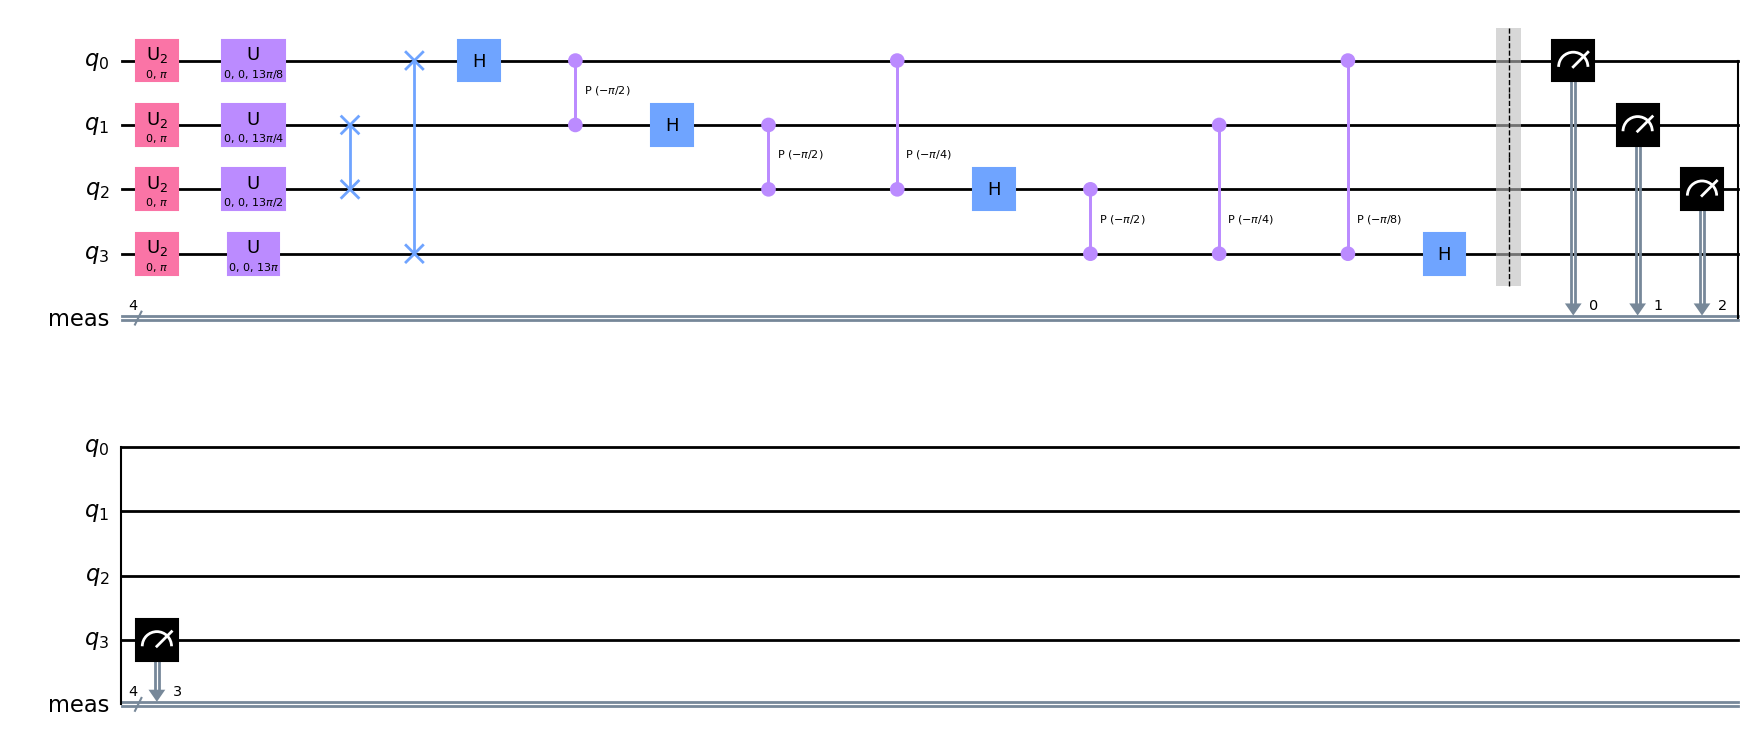

In [13]:
# Apply inverse QFT
inv_qc = inv_qft(qc1, 4)
inv_qc.measure_all()
inv_qc.draw('mpl')

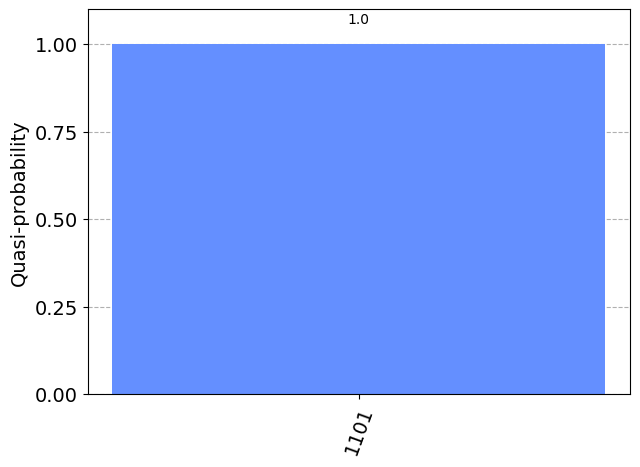

In [14]:
# check on simulator
counts = sim.run(qc_init).result().get_counts()
plot_histogram(counts)

### Quantum Phase Estimation

The circuit for quantum phase estimation is the following:

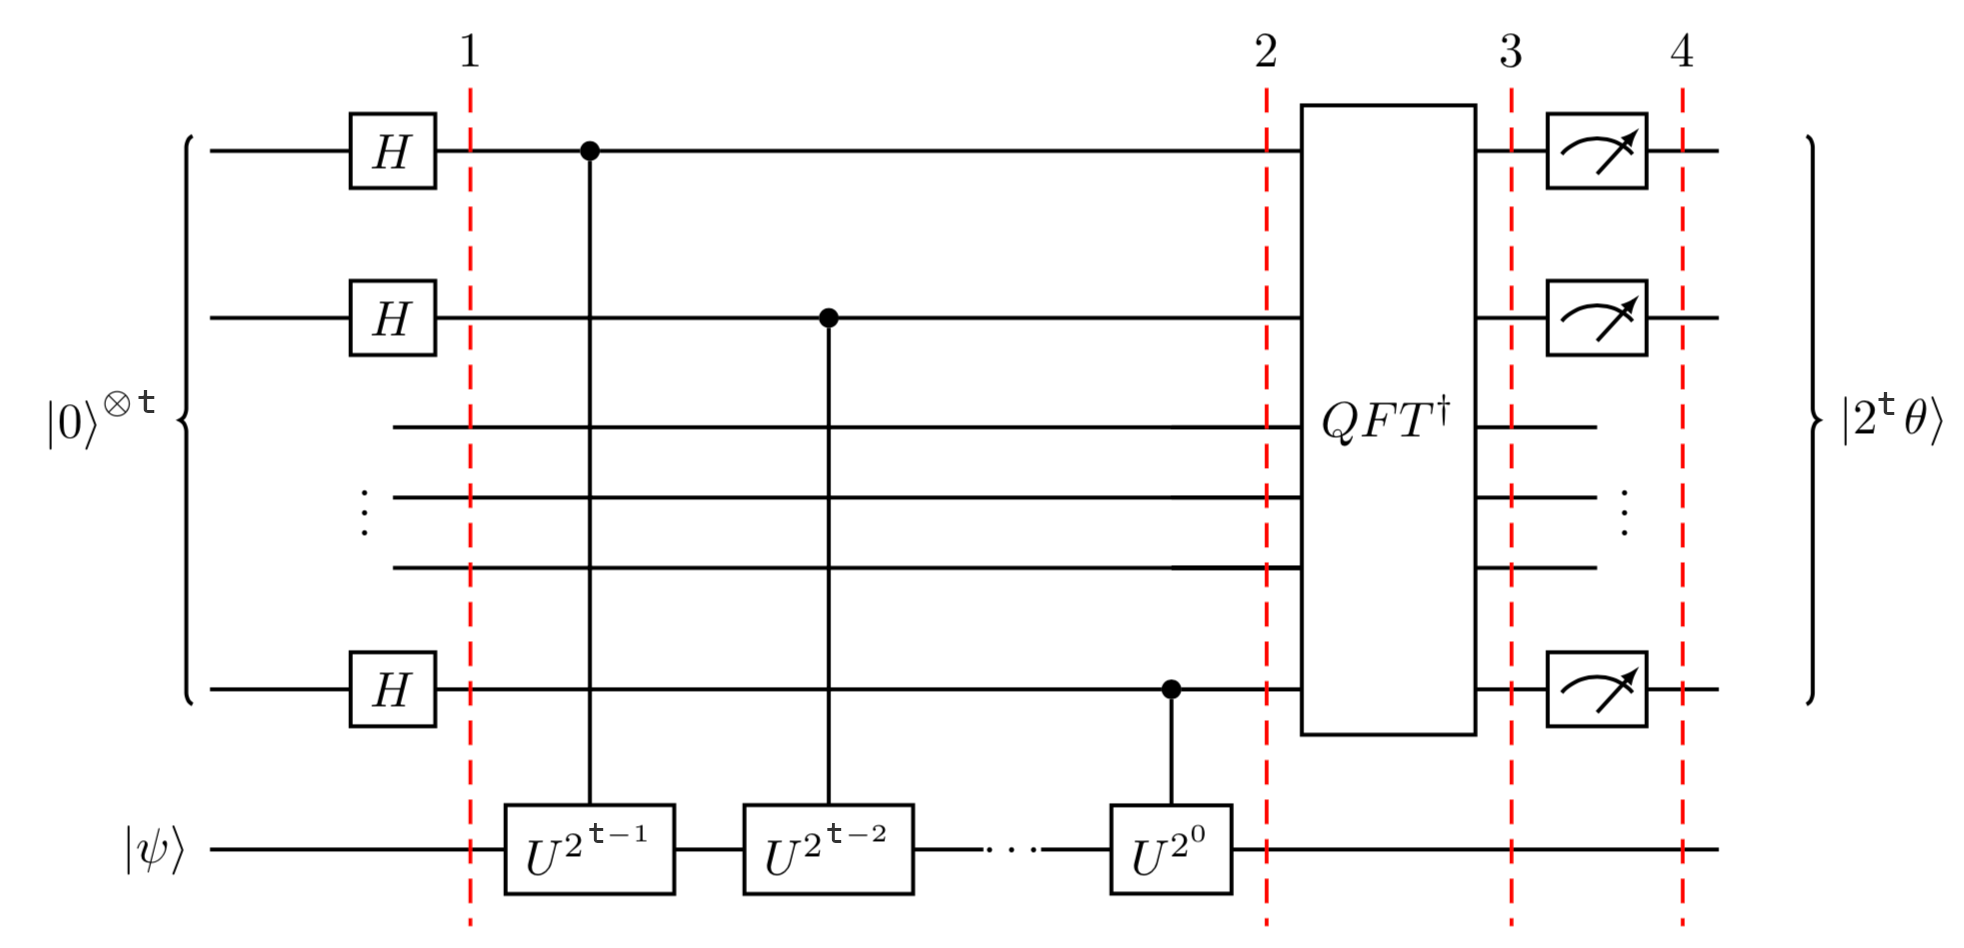

We look at an example, namely the $T$ gate. The $T$ gate adds a phase $e^{i\pi/4} $ to the state $\vert 1\rangle$: 
$$ T \vert 1 \rangle = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\pi /4} \end{bmatrix} \begin{bmatrix} 0 \\ 1 \end{bmatrix} = e^{i\pi/4} \vert 1 \rangle $$
Using quantum phase estimation we expect to find $\theta = 1/8$.

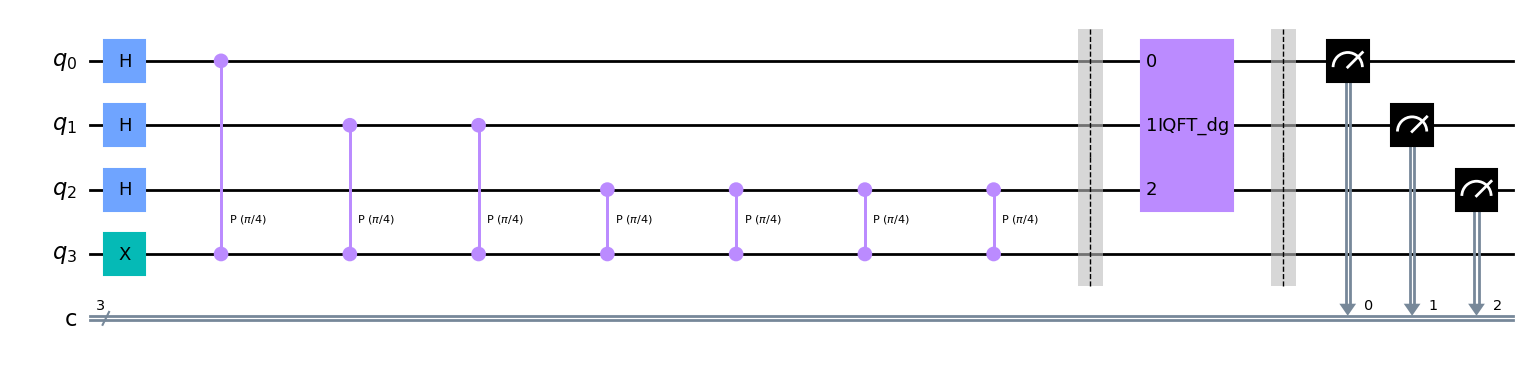

In [15]:
# initialize 

qpe = QuantumCircuit(4, 3)
qpe.x(3)
# apply the hadamard gates
for qubit in range(3):
    qpe.h(qubit)

j = 1
for qubit in range(3):
    for i in range(j):
        qpe.cp(np.pi/4, qubit, 3)
    j *= 2

qpe.barrier()
# apply inverse QFT, we use the in built QFT function
from qiskit.circuit.library import QFT
qpe = qpe.compose(QFT(3, inverse=True), [0,1,2])
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

qpe.draw('mpl')

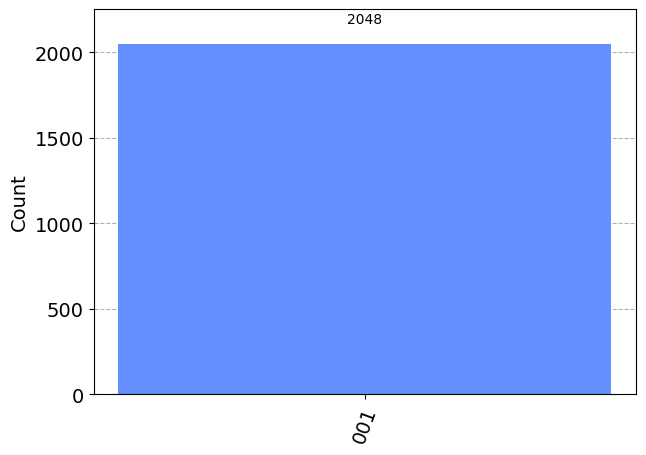

In [16]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We see we get one result $001$ with certainty, which translates to the decimal number $1$. We now need to divide our result $1$ by $2^n$ to get $\theta$: $$ \theta = \frac{1}{2^3} = \frac{1}{8}, $$ which we expected!

If instead we had a gate with $\theta = 1/3$, we can not precicely find the phase, rather can only estimate it. Let's see this in the following example.

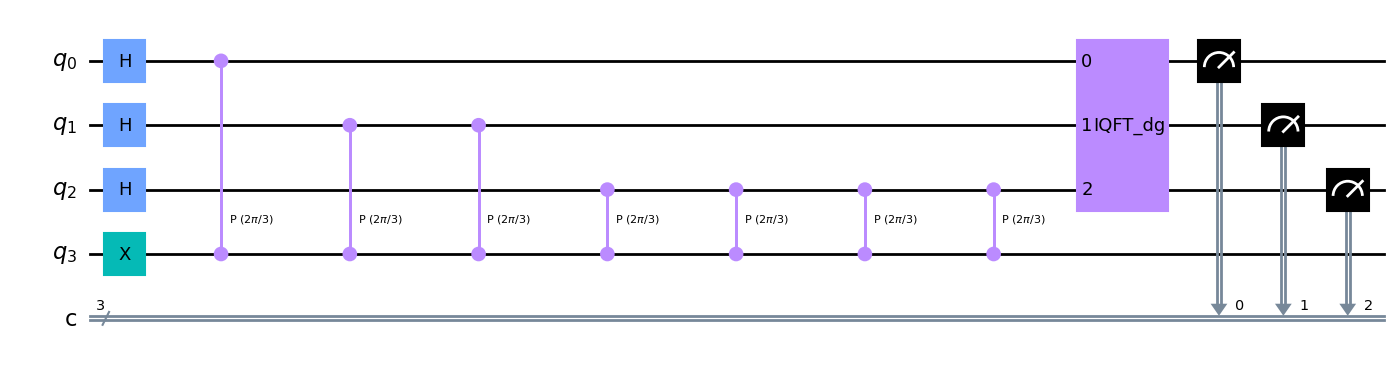

In [17]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*np.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qpe2 = qpe2.compose(QFT(3, inverse=True), [0,1,2])

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw('mpl')

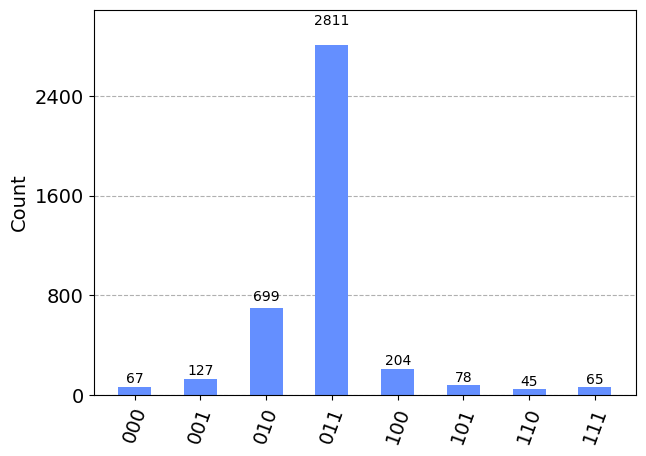

In [18]:
# Let's see the results!
shots = 4096
t_qpe2 = transpile(qpe2, aer_sim)
results = aer_sim.run(t_qpe2, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We are expecting the result $\theta = 1/3$, and we see our most likely results are $010$ or $011$, which is $2$ or $3$. These two results would tell us that $\theta =1/4$ (off by $25 \%$) or $\theta = 3/8$ (off by $13 \%$) respectively. The true value of $\theta$ lies between the values. To get more precicion we can add more qubits.

### Shor's Algorithm

We will solve the quantum part of the factoring problem. For positive integers $a$ and $N$ with $a<N$ and $\mathrm{gcd} (a, N) =1$, the period is the smallest non-zero integer $r$ such that $$ a^r \mathrm{mod} N =1 .$$
The goal is to find the period $r$.

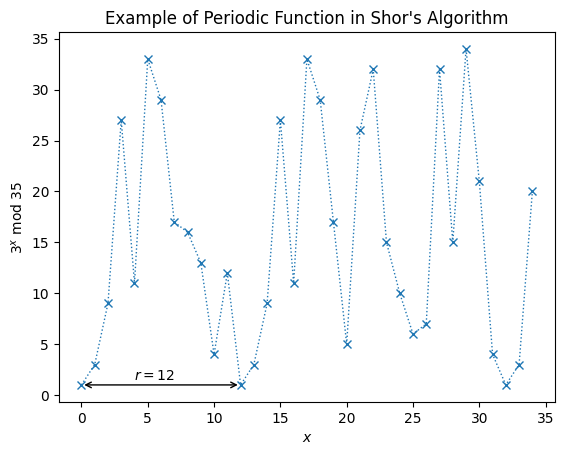

In [22]:
# Examples of periods
N = 35
a = 3
import matplotlib.pyplot as plt
# Calculate the plotting data
xvals = np.arange(N)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

Shor's algorithm uses Quantum Phase Estimation on the unitary operator $$ U\vert y \rangle = \vert ay \text{ mod } N \rangle $$
If we started in the state $\vert 1\rangle$, we can see that each successive application of $U$ will multiply the state of our register by $a \text{ mod } N$, and after $r$ applications we will arrive at the state $\vert 1 \rangle$ again. So, the superposition $$ \vert u_0 \rangle =  \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} \vert a^k \text{ mod } N \rangle $$ is an eigenstate of $U$. This eigenstate has an eigenvalue of 1, which isn’t very interesting. A more interesting eigenstate could be one in which the phase is different for each of these computational basis states. Specifically, let’s look at the case in which the phase of the $k$-th state is proportional to $k$: 
$$\vert u_1 \rangle =  \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2\pi ik}{r}} \vert a^k \text{ mod } N \rangle  $$
$$ U \vert u_1 \rangle = e^{\frac{2\pi i}{r}} \vert u_1 \rangle $$
This is a particularly interesting eigenvalue as it contains $r$. In fact, $r$ has to be included to make sure the phase differences between the  computational basis states are equal. This is not the only eigenstate with this behaviour; to generalise this further, we can multiply an integer $s$ to this phase difference, which will show up in our eigenvalue:
$$\vert u_s \rangle =  \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2\pi isk}{r}} \vert a^k \text{ mod } N \rangle  $$
$$ U \vert u_s \rangle = e^{\frac{2\pi is}{r}} \vert u_1 \rangle $$
This also has the property that $$ \frac{1}{\sqrt{r}} \sum_{s=0}^{r-1} \vert u_s \rangle = \vert 1 \rangle $$
Since the computational basis state $\vert 1 \rangle$ is a superposition of these eigenstates, which means if we do `QPE` on $U$ using the state $\vert 1 \rangle$, we will measure a phase: $$\phi = \frac{s}{r} $$ where $s$ is a random integer between $0$ and $r-1$. We finally use the continued fractions algorithm on $\phi$ to find $r$. The circuit diagram looks like this
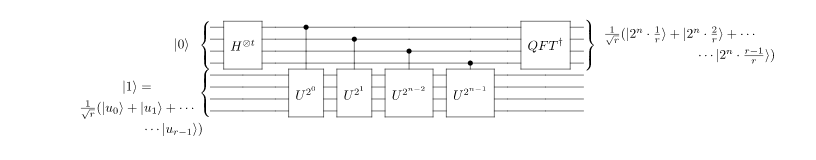

In [33]:
# We solve period finding problem for N=15
# The function c_amod15 returns the controlled-U gate for a, repeated power times.
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [62]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 8

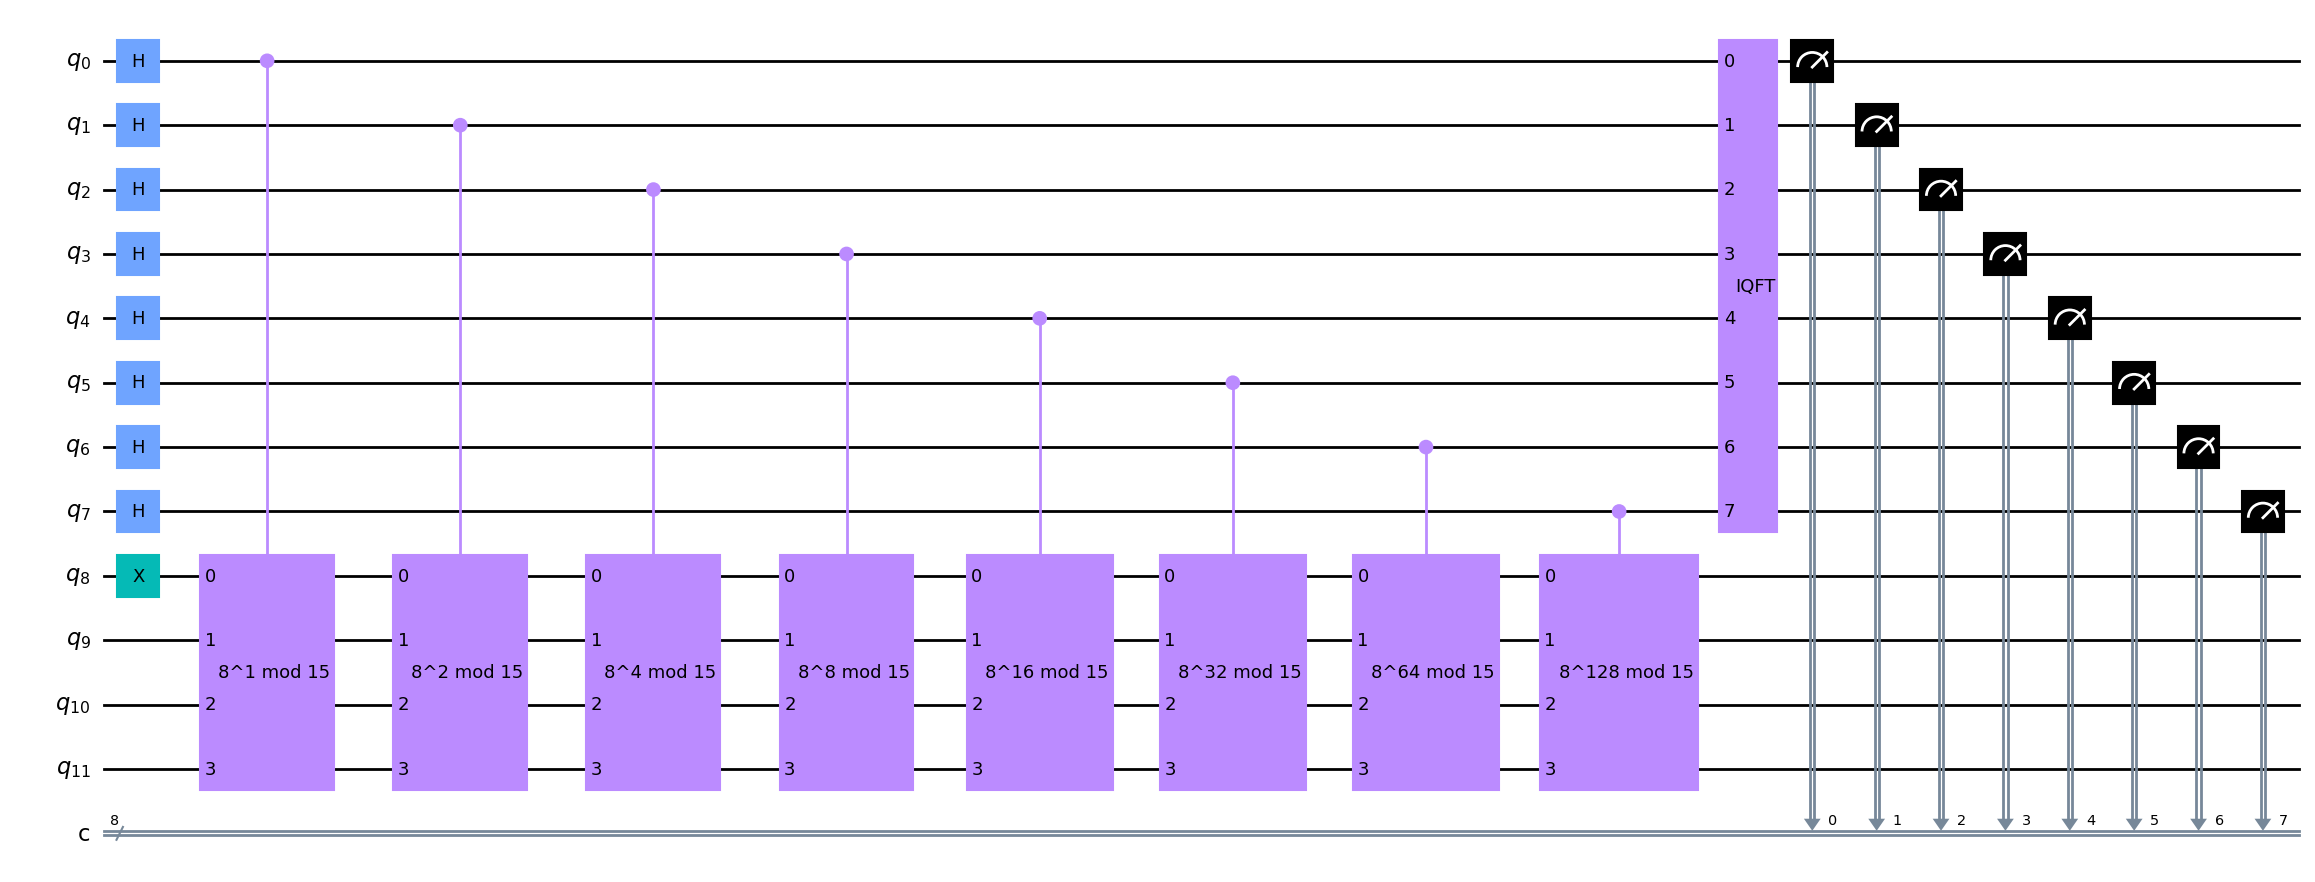

In [63]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for qubit in range(N_COUNT):
    qc.h(qubit)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for qubit in range(N_COUNT):
    qc.append(c_amod15(a, 2**qubit), [qubit] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(QFT(N_COUNT, inverse=True), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw('mpl', fold=-1)   

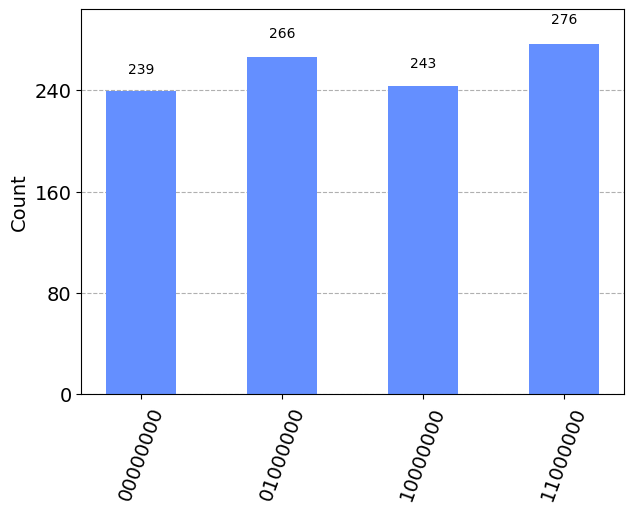

In [64]:
# measurement results
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

Since we have 8 qubits, these results correspond to measured phases of:

In [65]:
import pandas as pd
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
df

,Register Output,Phase
0,11000000(bin) = 192(dec),192/256 = 0.75
1,00000000(bin) = 0(dec),0/256 = 0.00
2,01000000(bin) = 64(dec),64/256 = 0.25
3,10000000(bin) = 128(dec),128/256 = 0.50


In [66]:
from fractions import Fraction
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.00      0/1            1
2   0.25      1/4            4
3   0.50      1/2            2


We can see that two of the measured eigenvalues provided us with the correct result: $r=4$, and we can see that Shor’s algorithm has a chance of failing. These bad results are because $s=0$, or because $s$ and $r$ are not coprime and instead of $r$ we are given a factor of $r$. The easiest solution to this is to simply repeat the experiment until we get a satisfying result for $r$.

### Modular Exponentiation

The method of creating the $U^{2^j}$ gates by repeating $U$ grows exponentially with $j$ and will not result in a polynomial time algorithm. We want a way to create the operator: $$ U^{2^j} \vert y \rangle = \vert a^{2^j} y \text{ mod } N \rangle $$ that grows polynomially with $j$. Fortunately, calculating: $$ a^{2^j} \text{ mod } N $$ efficiently is possible. Classical computers can use an algorithm known as *repeated squaring* to calculate an exponential. In our case, since we are only dealing with exponentials of the form $2^j$, the repeated squaring algorithm becomes very simple:

In [67]:
def a_2jmodN(a, j, N):
    ''' Computes a^{2^j} mod N '''
    for _ in range(j):
        a = np.mod(a**2 , N)
    return a

In [70]:
# Factoring 15 using period finding
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), [q] + [i+N_COUNT for i in range(4)])
        
    qc.append(QFT(N_COUNT, inverse=True), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [72]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

Register Reading: 00000000
Corresponding Phase: 0.0
1


In [75]:
from math import gcd
# repeats the algorithm until at least one factor of 15 is found
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print("*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 10000000
Corresponding Phase: 0.5
Result: r = 2
Guessed Factors: 1 and 1

ATTEMPT 2:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 3:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 4:
Register Reading: 10000000
Corresponding Phase: 0.5
Result: r = 2
Guessed Factors: 1 and 1

ATTEMPT 5:
Register Reading: 10000000
Corresponding Phase: 0.5
Result: r = 2
Guessed Factors: 1 and 1

ATTEMPT 6:
Register Reading: 11000000
Corresponding Phase: 0.75
Result: r = 4
Guessed Factors: 1 and 5
*** Non-trivial factor found: {guess} ***
